# Collaborative Filtering
In this HW, you will build an exmaple mode of Collaborative Filtering recommendation system. Specifically, you will use K Nearest Neighbor method in your model to find K most similar users. From those users, you will help predict what is the missing rating value ? for any item i that your new user x hasn't look at, yet.

## Table of Content 
1. Model Preview & Dataset
2. KNN
    1. Imports & Data Loader
    2. Data Filtering & Preview
        - Many unpopular movies
        - Many inactive users

## Model Preview & Dataset
I will use KNN model, Item-based recommendation system style. The dataset we will be using today is a smaller version (~1MB) of the MovieLens data set. In your HW zip file, you should see a folder called "ml-latest-small". If you don't please download it to your HW folder and zip from this website ASAP: https://grouplens.org/datasets/movielens/latest/. You need the dataset to start working on your code.

## KNN
### Imports & Data Loader
Make sure you have the following Python libraries downloaded. If not, use pip or pip3 to download them and restart the kernel to load the properly to this notebook run.
* pandas
* scipy
* matplotlib

In [4]:
from google.colab import drive
drive.mount('/content/drive/')
DRIVE_PREFIX = '/content/drive/My Drive/Colab Notebooks'

Mounted at /content/drive/


In [5]:
import math
import os
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')

%matplotlib inline

Set file names of our movies and ratings csv.

In [6]:
data_path = os.path.join(DRIVE_PREFIX, 'data')
file_movies = 'movies.csv'
file_ratings = 'ratings.csv'

Load movies and ratings into a pandas table using ".read_csv". Save them to the **movies** and **ratings** table.

In [7]:
movies = pd.read_csv(
    os.path.join(data_path, file_movies),
    usecols=['movieId', 'title'],
    dtype={'movieId': 'int32', 'title': 'str'})

ratings = pd.read_csv(
    os.path.join(data_path, file_ratings),
    usecols=['userId', 'movieId', 'rating'],
    dtype={'userId': 'int32', 'movieId': 'int32', 'rating': 'float32'})

Let's look at the data we're trying to work with before applying a CF KNN model. Run these cell below to familiarize yourself with the data structure. Print out the movies and ratings table:

In [8]:
movies

,movieId,title
0,1,Toy Story (1995)
1,2,Jumanji (1995)
2,3,Grumpier Old Men (1995)
3,4,Waiting to Exhale (1995)
4,5,Father of the Bride Part II (1995)
...,...,...
9737,193581,Black Butler: Book of the Atlantic (2017)
9738,193583,No Game No Life: Zero (2017)
9739,193585,Flint (2017)
9740,193587,Bungo Stray Dogs: Dead Apple (2018)


In [9]:
ratings

,userId,movieId,rating
0,1,1,4.0
1,1,3,4.0
2,1,6,4.0
3,1,47,5.0
4,1,50,5.0
...,...,...,...
100831,610,166534,4.0
100832,610,168248,5.0
100833,610,168250,5.0
100834,610,168252,5.0


Now we want to find **U** number of unique users and **I** number of unique movies. Use the combination of the functions **pd.unique()** and **len()** on the columns userId and movieId to get the unique number of users and movies.

In [10]:
unique_users = len(pd.unique(ratings["userId"]))
unique_movies = len(pd.unique(movies["movieId"]))
print("Number of users: ", unique_users, ". Number of movies: ", unique_movies)

Number of users:  610 . Number of movies:  9742


Other than just the unique number of users and movies, there are interesting properties of this dataset that we need to know to filter some data before putting them into our model. Specifically, we have a sparse rating problem (lots of 0') because of **2 reasons**:
1. **Many unpopular movies:** Some movies are just not worth rated (no hurty feelies. They are so mediocre, poorly made, or relatively unknown that people don't rate much.
2. **Many inactive users:** those who only rate once when they feel like it and never rate anything else.

### Data Filtering & Preview
In reality, a person would rate a movie when they feel like it (i.e. loves/hates that movie, etc ). The rest of the time, that person won't even rate. This makes sense in the real world, as you would only have time to watch a few movies, and you only have time to rate a few of those movies you watched. So our rating matrix is very sparse. In fact, most of the time, it will never be a complete matrix!

Let's see how badly sparse our matrix is :(. Define "sparse" as values that are at 0. This just mean that by default our data collecting system set unrated values (N/A) to 0, for easier data calculation later on. Run this cell below.

In [11]:
each_ratings = pd.DataFrame(ratings.groupby('rating').size(), columns=['count'])
total = unique_users * unique_movies
zero_count = total - ratings.shape[0]
each_ratings = each_ratings.append(
    pd.DataFrame({'count': zero_count}, index=[0.0]),
    verify_integrity=True,
).sort_index()
each_ratings

,count
0.0,5841784
0.5,1370
1.0,2811
1.5,1791
2.0,7551
2.5,5550
3.0,20047
3.5,13136
4.0,26818
4.5,8551


Woah! We have so many 0 ratings! That just means that most people didn't rate most of the movies out there. This makes sense. Another way to word it is: A person typically only rate a few movies.

Let's see 2 possible reasons why this is happening.

#### Many unpopular movies 
Only a few movies get a lot of rating attention. This is because of the the quality, low/high budget, among many other factors that makes a movie good or not. So the well-produced ones usually get more ratings, while the opposite gets few ratings.

Let's compute the number of ratings (rating frequency) per movie (movieId). Run this cell below to compute and graph the movies rating frequency:

Text(0, 0.5, 'number of ratings')

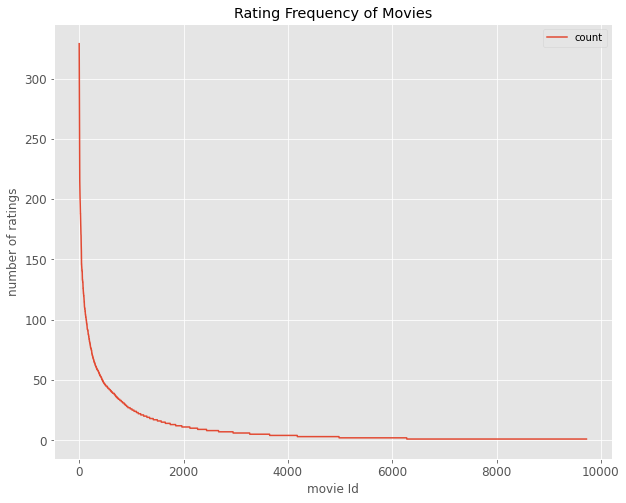

In [12]:
movies_ratecount = pd.DataFrame(ratings.groupby('movieId').size(), columns=['count'])
plot = movies_ratecount.sort_values('count', ascending=False) \
    .reset_index(drop=True).plot(
        figsize=(10, 8),
        title='Rating Frequency of Movies',
        fontsize=12
    )
plot.set_xlabel("movie Id")
plot.set_ylabel("number of ratings")

You can see that most movies barely get any ratings, while only a few gets tons of ratings. Therefore, for our data, we will only look at movies that have at least some number of ratings. Call that **rating_threshold**.

Your task is to set **rating_threshold** to 50 and compute only the movies that are >= **rating_threshold** from the **movies_ratecount** table. Save this to a new table called **popmovies_ratecount**. (*Hint: search up about how to filter for Pandas tables*)

In [13]:
rating_threshold = 50
popmovies_ratecount = movies_ratecount[movies_ratecount["count"] >= rating_threshold]
print("Original movies table shape:", movies_ratecount.shape)
print("New popular movies table shape:", popmovies_ratecount.shape)

Original movies table shape: (9724, 1)
New popular movies table shape: (450, 1)


#### Many inactive users
Not all users are active. Some just wanted to be on the rating platform to rate the movie they like/hate/ambivalent for a few times. Let's see the "active" distribution (rating frequency) among the users. 

In [14]:
ratings_popmovies = ratings[ratings.movieId.isin(set(popmovies_ratecount.index))]
users_cnt = pd.DataFrame(ratings_popmovies.groupby('userId').size(), columns=['count']).sort_values('count', ascending=False)
users_cnt

,count
userId,
414,429
68,396
599,388
274,349
480,349
...,...
578,2
207,2
138,2


Ploting the number of rates per user

Text(0, 0.5, 'number of ratings')

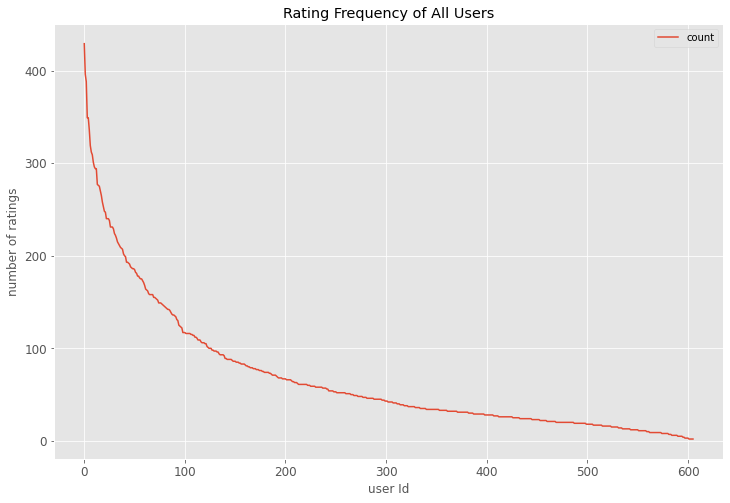

In [15]:
plot = users_cnt \
    .sort_values('count', ascending=False) \
    .reset_index(drop=True) \
    .plot(
        figsize=(12, 8),
        title='Rating Frequency of All Users',
        fontsize=12
    )
plot.set_xlabel("user Id")
plot.set_ylabel("number of ratings")

Notice that some users don't rate much, and others rate a lot. We want to have a minimum number of ratings to filter out the users we want to look at in our dataset. Give a rating threshold of 50 to **user_threshold**. Then, filter out the **users_cnt** table to have only users who rate >= 50, name this new table **users_cnt_filtered**.

In [22]:
user_threshold = 50
users_cnt_filtered = users_cnt[users_cnt["count"] >= user_threshold]
print("Before filter (dimensions):", users_cnt.shape)
print("After filter (dimensions):", users_cnt_filtered.shape)

Before filter (dimensions): (606, 1)
After filter (dimensions): (268, 1)
        count
userId       
414       429
68        396
599       388
274       349
480       349
...       ...
386        51
455        51
32         50
47         50
227        50

[268 rows x 1 columns]


## Train KNN model 
Now to the meaty part of your HW. You will write a KNN() class that predicts the output label from input rating vectors. Write some useful function skeleton for you: (you can use them or not depend on your choice)

- **__cosine_sim**: a private function in KNN that computes cosine similiarty number between two vectors. 
    - Input: 2 vectors **u** and **v**. 
    - Output: cosine similarity number of **u** and **v**. Reference equation:
    ![title](img/cossim.png)
- **recommend**: return a list of K movies that are the most similar to a reference movie call my_movie.

Feel free to add helper methods. You **MAY NOT use and pre-built functions in other libraries (i.e. sklearn, etc.)**.

Some tips: Think about how you can convert a table (data frame) into a dictionary/list/etc of movies and their rating vectors.

In [222]:
"""K-Nearest Neighbor algorithm that uses cosine similarity."""
class KNN():
    def __init__(self, k, movies, ratings):
        self.k = k
        self.movies = movies
        self.ratings_table = ratings.pivot(index='userId', columns='movieId', values='rating').fillna(0)
    
    """Compute the cosine similarity between 2 vectors"""
    def __cosine_sim(self, u, v):
        # Compute the cosine similarity between 2 vectors
        # Input: vectors u & v
        # Output: cosine similarity number between 2 vectors (see Equation)
        nom = np.sum(u * v)
        denom = np.sum(u ** 2) * np.sum(v ** 2)
        return nom / denom

    def __title_to_id(self, title):
        return movies[movies.title == title].iloc[0, 0]

    def __id_to_title(self, id):
        return movies[movies.movieId == id].iloc[0, 1]
    
    def recommend(self, title):
        my_movie_id = self.__title_to_id(title)
        my_movie_vector = self.ratings_table[my_movie_id].to_numpy()

        result = []
        for movie_id in self.ratings_table:
            if (my_movie_id == movie_id):
                continue
            vector = self.ratings_table[movie_id].to_numpy()
            nonzero_indices = np.intersect1d(vector.nonzero()[0], my_movie_vector.nonzero()[0])
            vector = np.take(vector, nonzero_indices)
            temp_vector = np.take(my_movie_vector, nonzero_indices)
            cosine_sim = self.__cosine_sim(vector, temp_vector)
            result.append((self.__id_to_title(movie_id), cosine_sim))

        result.sort(key=lambda x : x[1])
        result = list(map(lambda x : x[0], result))
        return result[0:self.k]

    # ADD MORE METHODS IF NEEDED. You can remove methods, too, and rename/use your own.

Run your KNN to recommend 10 movies that are similar to your **my_movie**.

In [223]:
filtered_ratings = ratings_popmovies[ratings_popmovies.userId.isin(set(users_cnt_filtered.index))]

my_movie = 'Iron Man (2008)' # You can change to other movie titles
k = 10

# RUN your KNN down here to see the resulting recommended movies. (PRINT out all those movies)
knn = KNN(k, movies, filtered_ratings)
knn.recommend(my_movie)

['Matrix, The (1999)',
 'Dark Knight, The (2008)',
 'Shawshank Redemption, The (1994)',
 'Forrest Gump (1994)',
 'Star Wars: Episode IV - A New Hope (1977)',
 'Lord of the Rings: The Return of the King, The (2003)',
 'Fight Club (1999)',
 'Lord of the Rings: The Two Towers, The (2002)',
 'Lord of the Rings: The Fellowship of the Ring, The (2001)',
 'Star Wars: Episode V - The Empire Strikes Back (1980)']